In [1]:
#Implementing necessary modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense


import yfinance as yf

In [2]:
#Initializing inputs
ticker = ['ETH-USD']
seed = 1
test_size = 0.1
start_date = '2010-01-01'
end_date = '2021-12-31'

In [3]:
#Data Handling
df = yf.download(ticker ,start=start_date,end=end_date)
date_df = df.index

df["H-L"] = df["High"] - df["Low"]
df["O-C"] = df["Open"] - df["Close"]
df["MA10"] = df["Adj Close"].rolling(window = 10).mean()
df["MA20"] = df["Adj Close"].rolling(window = 20).mean()
df["MA60"] = df["Adj Close"].rolling(window = 60).mean()
df["10D_STDEV"] = df["Adj Close"].rolling(window = 10).std()

#Trading Strategy (very simple)
df["flag"] = np.where((df["MA10"] > df["MA20"]), 1.0, 0.0)
df.dropna(inplace = True)

[*********************100%***********************]  1 of 1 completed


790
665


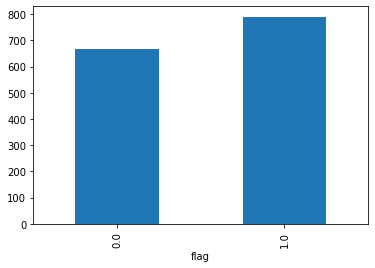

In [4]:
#Plot the ratio between buy and sell signals

fig = plt.figure()
plot = df.groupby(['flag']).size().plot(kind='bar')
print(sum(df['flag'] == 1.0))
print(sum(df['flag'] == 0.0))

In [5]:
#Modeling

Y = df['flag']
X = df.loc[:, df.columns != 'flag']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size=test_size, shuffle = False)

num_folds = 10
scoring = 'accuracy'
param_grid = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5, 10, 20],
    'criterion' : ["gini","entropy"]    
}

kfold = KFold(n_splits=num_folds, shuffle = False)
cv = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid=param_grid, scoring=scoring, cv=kfold)
cv_result = cv.fit(X_train, Y_train)

In [6]:
print("Best score:", cv_result.best_score_)
print("Best parameters:", cv_result.best_params_)

Best score: 0.6699177921315325
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}


In [7]:
#Implement the best model
model = RandomForestClassifier(criterion = 'entropy', max_depth = 10, n_estimators = 100)
model.fit(X_train, Y_train)

#Estimate the accuracy
Y_test_pred = model.predict(X_test)
print(accuracy_score(Y_test, Y_test_pred))

0.6643835616438356


0           NaN
1      5.114041
2     -0.825954
3      0.717892
4     -3.818630
         ...   
141   -0.732189
142   -5.861344
143   -4.534759
144    2.351373
145   -0.840616
Name: Market Returns, Length: 146, dtype: float64


<AxesSubplot:>

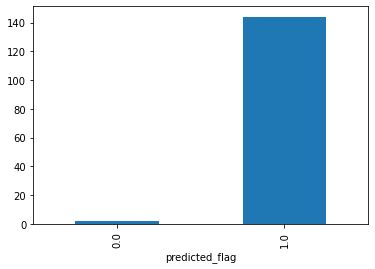

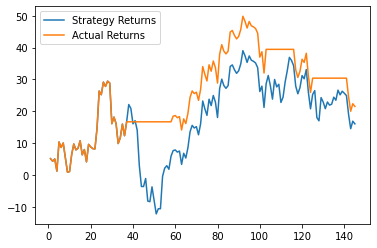

In [8]:
#Backtesting

backtest_df = pd.DataFrame(index=X_test.index)
backtest_df['predicted_flag'] = Y_test_pred
backtest_df['actual_flag'] = Y_test
backtest_df['Market Returns'] = (X_test['Adj Close'].pct_change())*100
backtest_df['Actual Returns'] = backtest_df['Market Returns'] * backtest_df['actual_flag'].shift(1)
backtest_df['Strategy Returns'] = backtest_df['Market Returns'] * backtest_df['predicted_flag'].shift(1)
backtest_df = backtest_df.reset_index()
print(backtest_df['Market Returns'])

backtest_df.groupby(['predicted_flag']).size().plot(kind='bar')
backtest_df[['Strategy Returns','Actual Returns']].cumsum().plot()